# Basic output

In [ ]:
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision.models import resnet50

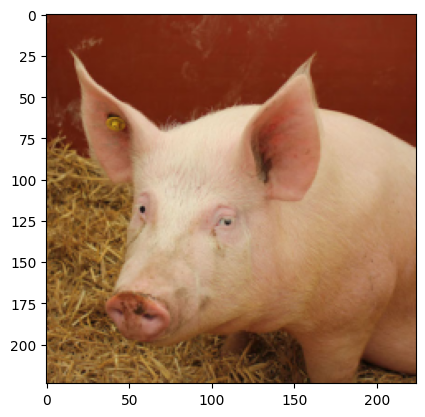

In [ ]:
# read the image, resize to 224 and convert to PyTorch Tensor
pig_img = Image.open("pig.jpg")
preprocess = transforms.Compose([
   transforms.Resize(224),
   transforms.ToTensor(),
])
pig_tensor = preprocess(pig_img)[None,:,:,:]

# plot image (note that numpy using HWC whereas Pytorch user CHW, so we need to convert)
plt.imshow(pig_tensor[0].numpy().transpose(1,2,0))

In [ ]:
# simple Module to normalize an image
class Normalize(nn.Module):
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.mean = torch.Tensor(mean)
        self.std = torch.Tensor(std)
    def forward(self, x):
        return (x - self.mean.type_as(x)[None,:,None,None]) / self.std.type_as(x)[None,:,None,None]

# values are standard normalization for ImageNet images,
# from https://github.com/pytorch/examples/blob/master/imagenet/main.py
norm = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

In [ ]:
# load pre-trained ResNet50, and put into evaluation mode (necessary to e.g. turn off batchnorm)
model = resnet50(pretrained=True)
model.eval();

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 237MB/s]


In [ ]:
pred = model(norm(pig_tensor))

In [ ]:
import json
with open("imagenet_class_index.json") as f:
    imagenet_classes = {int(i):x[1] for i,x in json.load(f).items()}
print(imagenet_classes[pred.max(dim=1)[1].item()])

hog


In [ ]:
print(nn.CrossEntropyLoss()(model(norm(pig_tensor)),torch.LongTensor([341])).item())

0.003882253309711814


# Adversarial example

maximize the loss of the correct class.

In [ ]:
import torch.optim as optim

In [ ]:
epsilon = 2./255
# Gradient of loss with respect to the pertubation (make pertubabtion small and add it to image)
# In normal way we take gradient of loss with respect to the model weights

delta = torch.zeros_like(pig_tensor, requires_grad=True)
opt = optim.SGD([delta], lr=1e-1)

for t in range(30):
    pred = model(norm(pig_tensor + delta))
    loss = -nn.CrossEntropyLoss()(pred, torch.LongTensor([341]))
    if t % 5 == 0:
        print(t, loss.item())

    opt.zero_grad()
    loss.backward()
    opt.step()
    # there is a restriction which it shouldn't be greater or smaller than epsilon
    delta.data.clamp_(-epsilon, epsilon)

print("True class probability:", nn.Softmax(dim=1)(pred)[0,341].item())

0 -0.003882253309711814
5 -0.006934741511940956
10 -0.015805913135409355
15 -0.0799558088183403
20 -11.142181396484375
25 -13.397157669067383
True class probability: 1.038025061461667e-06


In [ ]:
max_class = pred.max(dim=1)[1].item()
print("Predicted class: ", imagenet_classes[max_class])
print("Predicted probability:", nn.Softmax(dim=1)(pred)[0,max_class].item())

Predicted class:  wombat
Predicted probability: 0.9997883439064026


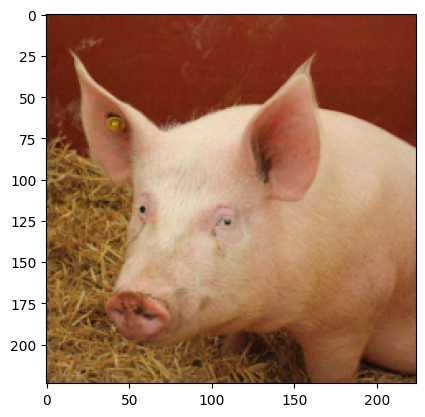

In [ ]:
plt.imshow((pig_tensor + delta)[0].detach().numpy().transpose(1,2,0))

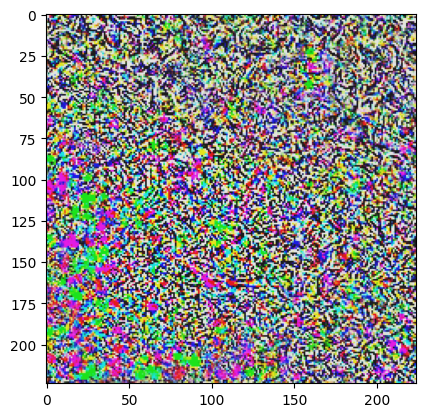

In [ ]:
plt.imshow((50*delta+0.5)[0].detach().numpy().transpose(1,2,0))


#Targeted attacks

Maximize the loss of the correct class, we maximize the loss of the correct class while also minimizing the loss of the target class.

In [ ]:
delta = torch.zeros_like(pig_tensor, requires_grad=True)
opt = optim.SGD([delta], lr=5e-3)

for t in range(100):
    pred = model(norm(pig_tensor + delta))
    loss = (-nn.CrossEntropyLoss()(pred, torch.LongTensor([341])) +
            nn.CrossEntropyLoss()(pred, torch.LongTensor([404])))
    if t % 10 == 0:
        print(t, loss.item())

    opt.zero_grad()
    loss.backward()
    opt.step()
    delta.data.clamp_(-epsilon, epsilon)

0 24.00604820251465
10 -0.15508747100830078
20 -7.620338439941406
30 -14.787199020385742
40 -21.15138816833496
50 -25.89435386657715
60 -30.196027755737305
70 -34.96584701538086
80 -38.666412353515625
90 -38.255027770996094


In [ ]:
max_class = pred.max(dim=1)[1].item()
print("Predicted class: ", imagenet_classes[max_class])
print("Predicted probability:", nn.Softmax(dim=1)(pred)[0,max_class].item())

Predicted class:  airliner
Predicted probability: 0.9149457812309265


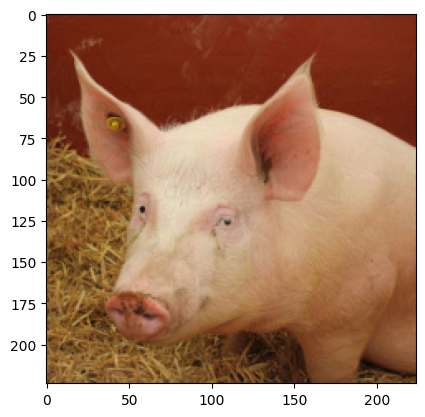

In [ ]:
plt.imshow((pig_tensor + delta)[0].detach().numpy().transpose(1,2,0))

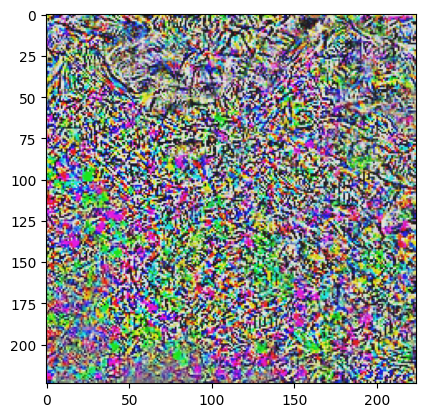

In [ ]:
plt.imshow((50*delta+0.5)[0].detach().numpy().transpose(1,2,0))

# Linear models

how well traditional linear models might work to also prevent adversarial examples

In [ ]:
import numpy as np
import  matplotlib.pyplot as plt

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [ ]:
mnist_train = datasets.MNIST("./data", train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.MNIST("./data", train=False, download=True, transform=transforms.ToTensor())

In [ ]:
# Filter the dataset based on labels
train_idx = mnist_train.targets <= 1  # Filter for labels 0 and 1
mnist_train.data = mnist_train.data[train_idx]
mnist_train.targets = mnist_train.targets[train_idx]

In [ ]:
# Filter the dataset based on labels
test_idx = mnist_test.targets <= 1  # Filter for labels 0 and 1
mnist_test.data = mnist_test.data[test_idx]
mnist_test.targets = mnist_test.targets[test_idx]

In [ ]:
train_loader = DataLoader(mnist_train, batch_size = 100, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size = 100, shuffle=False)

In [ ]:
def epoch(loader, model, opt=None):
    total_loss, total_err = 0.,0.
    for X,y in loader:
        yp = model(X.view(X.shape[0], -1))[:,0]
        loss = nn.BCEWithLogitsLoss()(yp, y.float())
        if opt:
            opt.zero_grad()
            loss.backward()
            opt.step()
        total_err += ((yp > 0) * (y==0) + (yp < 0) * (y==1)).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)

In [ ]:
model = nn.Linear(784, 1)
opt = optim.SGD(model.parameters(), lr=1.)
print("Train Err", "Train Loss", "Test Err", "Test Loss", sep="\t")
for i in range(10):
    train_err, train_loss = epoch(train_loader, model, opt)
    test_err, test_loss = epoch(test_loader, model)
    print(*("{:.6f}".format(i) for i in (train_err, train_loss, test_err, test_loss)), sep="\t")

Train Err	Train Loss	Test Err	Test Loss
0.005211	0.015176	0.000473	0.003107
0.001421	0.005517	0.000473	0.002491
0.001105	0.004487	0.000473	0.002244
0.001105	0.003888	0.000473	0.002121
0.000947	0.003581	0.000946	0.002054
0.000869	0.003196	0.000473	0.002065
0.000790	0.003062	0.000473	0.001912
0.000790	0.002777	0.000946	0.001902
0.000869	0.002694	0.000473	0.001885
0.000711	0.002560	0.000473	0.001830


error rate of 0.0004 means 1 wrong in **test set**.

Text(0.5, 1.0, 'True Label: 0')

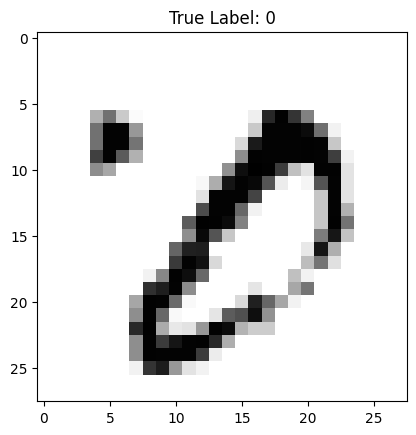

In [ ]:
X_test = (test_loader.dataset.test_data.float()/255).view(len(test_loader.dataset),-1)
y_test = test_loader.dataset.test_labels
yp = model(X_test)[:,0]
# which doesn’t depend on x, this means that the best perturbation to apply is the same across all examples.
idx = (yp > 0) * (y_test == 0) + (yp < 0) * (y_test == 1)
plt.imshow(1-X_test[idx][0].view(28,28).numpy(), cmap="gray")
plt.title("True Label: {}".format(y_test[idx].item()))

It’s perhaps not all that obvious, but if you squint you can see that maybe there is a vertical line (like a 1) in black pixels, and a cirlce (like a 0) in in white. The intuition here is that moving in the black direction, we make the classifier think the image is more like a 1, while moving in the white direction, more like a 0.

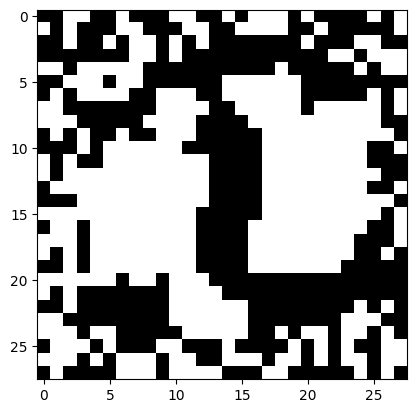

In [ ]:
epsilon = 0.2
delta = epsilon * model.weight.detach().sign().view(28,28)
plt.imshow(1-delta.numpy(), cmap="gray")

In [ ]:
def epoch_adv(loader, model, delta):
    total_loss, total_err = 0.,0.
    for X,y in loader:
        yp = model((X-(2*y.float()[:,None,None,None]-1)*delta).view(X.shape[0], -1))[:,0]
        loss = nn.BCEWithLogitsLoss()(yp, y.float())
        total_err += ((yp > 0) * (y==0) + (yp < 0) * (y==1)).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)
print(epoch_adv(test_loader, model, delta[None,None,:,:]))

(0.8401891252955083, 3.244136430411192)


From 0 error to 82.8% error rate.

(it is recognizable for humans)

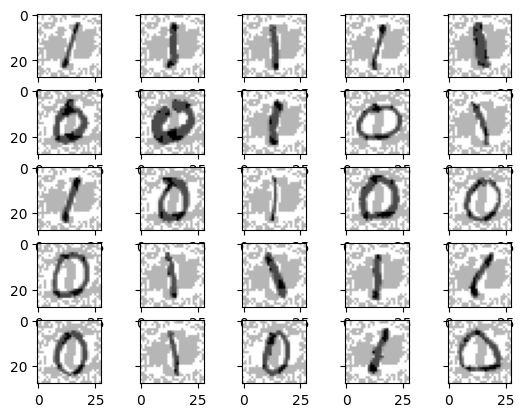

In [ ]:
f,ax = plt.subplots(5,5, sharey=True)
for i in range(25):
    ax[i%5][i//5].imshow(1-(X_test[i].view(28,28) - (2*y_test[i]-1)*delta).numpy(), cmap="gray")
    ax

Training robust linear models

ℓ∞ ball with ϵ=0.2 could easily create 100% error.

we can perform exact robust optimization by simply incorporating the ℓ1 norm into the objective.

we just subtract ϵ(2y−1) ∥w∥1 from the predictions (the 2y−1 scales the 0/1 entries to -1/+1).


In [ ]:
def epoch_robust(loader, model, epsilon, opt=None):
    total_loss, total_err = 0.,0.
    for X,y in loader:
        yp = model(X.view(X.shape[0], -1))[:,0] - epsilon*(2*y.float()-1)*model.weight.norm(1)
        loss = nn.BCEWithLogitsLoss()(yp, y.float())
        if opt:
            opt.zero_grad()
            loss.backward()
            opt.step()

        total_err += ((yp > 0) * (y==0) + (yp < 0) * (y==1)).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)

In [ ]:
model = nn.Linear(784, 1)
opt = optim.SGD(model.parameters(), lr=1e-1)
epsilon = 0.2
print("Rob. Train Err", "Rob. Train Loss", "Rob. Test Err", "Rob. Test Loss", sep="\t")
for i in range(20):
    train_err, train_loss = epoch_robust(train_loader, model, epsilon, opt)
    test_err, test_loss = epoch_robust(test_loader, model, epsilon)
    print(*("{:.6f}".format(i) for i in (train_err, train_loss, test_err, test_loss)), sep="\t")

Rob. Train Err	Rob. Train Loss	Rob. Test Err	Rob. Test Loss
0.150099	0.378674	0.064775	0.214361
0.072088	0.223172	0.051064	0.171155
0.062456	0.197316	0.043026	0.157616
0.058034	0.183975	0.042080	0.146756
0.053060	0.174692	0.037352	0.133904
0.049349	0.168052	0.036407	0.126340
0.048006	0.162762	0.038298	0.132336
0.045085	0.158190	0.034988	0.125896
0.043979	0.154651	0.029787	0.120227
0.043348	0.151618	0.026950	0.112518
0.041137	0.148967	0.028369	0.116707
0.040426	0.146734	0.028369	0.116503
0.039321	0.145077	0.026478	0.109419
0.038610	0.143331	0.027423	0.112998
0.037742	0.141624	0.026478	0.111438
0.037031	0.140321	0.027423	0.110533
0.036557	0.139209	0.025532	0.102830
0.034978	0.137967	0.024586	0.101612
0.034978	0.137135	0.024586	0.100498
0.034741	0.136232	0.023641	0.098449


no adversarial attack can lead to more then 2.5% error on the test set.

But how well does it do on the non-adversarial **training set**?

(model optimizer has been robust to adversarials)

In [ ]:
train_err, train_loss = epoch(train_loader, model)
test_err, test_loss = epoch(test_loader, model)
print("Train Err", "Train Loss", "Test Err", "Test Loss", sep="\t")
print(*("{:.6f}".format(i) for i in (train_err, train_loss, test_err, test_loss)), sep="\t")

Train Err	Train Loss	Test Err	Test Loss
0.006080	0.015162	0.003783	0.008162


We’re getting 0.3% error on the test set. This is good, but not as good as we were doing with standard training; we’re now making 8 mistakes on the test set, instead of the 1 that we were making before.

trade off between clean accuracy and robust accuracy, and doing better on the robust error leads to higher clean error.

optimal perturbation for this robust model.

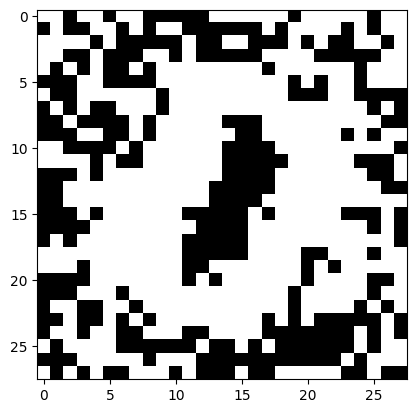

In [ ]:
delta = epsilon * model.weight.detach().sign().view(28,28)
plt.imshow(1-delta.numpy(), cmap="gray")

# Irregular Cost Surface of Neural Networks

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
torch.manual_seed(0)
# Input layer takes (batch_size,1)
# create output of (batch_size,100)
# and so on.
model = nn.Sequential(nn.Linear(1,100), nn.ReLU(),
                      nn.Linear(100,100), nn.ReLU(),
                      nn.Linear(100,100), nn.ReLU(),
                      nn.Linear(100,1))

In [ ]:
opt = optim.SGD(model.parameters(),lr=1e-2)

In [ ]:
for _ in range(100):
    loss = nn.MSELoss()(model(torch.randn(100,1)), torch.randn(100,1))
    opt.zero_grad()
    loss.backward()
    opt.step()

In [ ]:
torch.arange(-3,3,0.01)

torch.Size([600, 1])

Text(0, 0.5, 'Output')

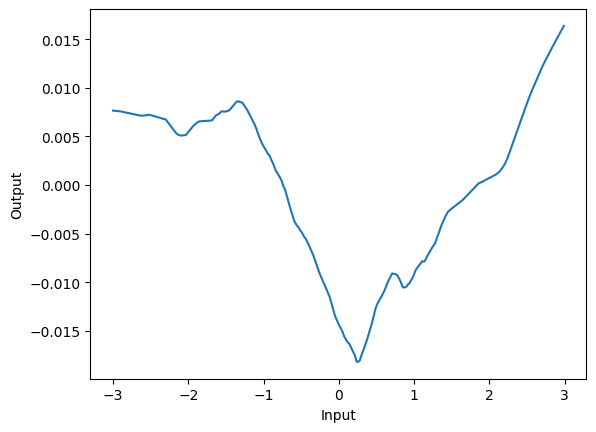

In [ ]:
plt.plot(np.arange(-3,3,0.01), model(torch.arange(-3,3,0.01)[:,None]).detach().numpy())
plt.xlabel("Input")
plt.ylabel("Output")

# Solving the inner maximization

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Train the model

In [ ]:
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.shape[0], -1)

In [ ]:
model_dnn_2 = nn.Sequential(Flatten(), nn.Linear(784,200), nn.ReLU(),
                            nn.Linear(200,10)).to(device)

In [ ]:
model_dnn_4 = nn.Sequential(Flatten(), nn.Linear(784,200), nn.ReLU(),
                            nn.Linear(200,100), nn.ReLU(),
                            nn.Linear(100,100), nn.ReLU(),
                            nn.Linear(100,10)).to(device)

In [ ]:
model_cnn = nn.Sequential(nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(),
                          nn.Conv2d(32, 32, 3, padding=1, stride=2), nn.ReLU(),
                          nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
                          nn.Conv2d(64, 64, 3, padding=1, stride=2), nn.ReLU(),
                          Flatten(),
                          nn.Linear(7*7*64, 100), nn.ReLU(),
                          nn.Linear(100, 10)).to(device)

In [ ]:
mnist_train = datasets.MNIST("../data", train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.MNIST("../data", train=False, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(mnist_train, batch_size = 100, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size = 100, shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 249144331.92it/s]


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 38813102.80it/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 206611041.63it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw




100%|██████████| 4542/4542 [00:00<00:00, 6401387.35it/s]


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



In [ ]:
def epoch(loader, model, opt=None):
    total_loss, total_err = 0.,0.
    for X,y in loader:
        X,y = X.to(device), y.to(device)
        yp = model(X)
        loss = nn.CrossEntropyLoss()(yp,y)
        if opt:
            opt.zero_grad()
            loss.backward()
            opt.step()

        total_err += (yp.max(dim=1)[1] != y).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)

In [ ]:
opt = optim.SGD(model_dnn_2.parameters(), lr=1e-1)
for _ in range(10):
    train_err, train_loss = epoch(train_loader, model_dnn_2, opt)
    test_err, test_loss = epoch(test_loader, model_dnn_2)
    print(*("{:.6f}".format(i) for i in (train_err, train_loss, test_err, test_loss)), sep="\t")

0.133317	0.516272	0.083200	0.284696
0.074800	0.262570	0.063800	0.222465
0.058883	0.207493	0.052200	0.180590
0.048467	0.170988	0.044600	0.153375
0.041550	0.145569	0.039100	0.135079
0.035283	0.126236	0.035600	0.120655
0.031233	0.111628	0.032900	0.112769
0.027633	0.100271	0.029500	0.102852
0.025333	0.090397	0.028800	0.097410
0.022550	0.082325	0.027600	0.092271


In [ ]:
opt = optim.SGD(model_dnn_4.parameters(), lr=1e-1)
for _ in range(10):
    train_err, train_loss = epoch(train_loader, model_dnn_4, opt)
    test_err, test_loss = epoch(test_loader, model_dnn_4)
    print(*("{:.6f}".format(i) for i in (train_err, train_loss, test_err, test_loss)), sep="\t")

0.256317	0.831741	0.082100	0.269916
0.068067	0.228195	0.047100	0.160782
0.043183	0.144717	0.039800	0.127341
0.032533	0.107598	0.034600	0.110751
0.026083	0.084599	0.028200	0.087761
0.020817	0.068876	0.030600	0.095773
0.017183	0.056357	0.027400	0.087058
0.014500	0.047615	0.022100	0.070932
0.011850	0.038920	0.023600	0.075482
0.009583	0.032907	0.020000	0.066735


In [ ]:
opt = optim.SGD(model_cnn.parameters(), lr=1e-1)
for t in range(10):
    train_err, train_loss = epoch(train_loader, model_cnn, opt)
    test_err, test_loss = epoch(test_loader, model_cnn)
    if t == 4:
        for param_group in opt.param_groups:
            param_group["lr"] = 1e-2
    print(*("{:.6f}".format(i) for i in (train_err, train_loss, test_err, test_loss)), sep="\t")

0.261183	0.748672	0.029800	0.092438
0.027317	0.088256	0.018500	0.059347
0.016917	0.055661	0.019400	0.060087
0.013017	0.040630	0.016500	0.052861
0.010050	0.031534	0.011700	0.039538
0.004317	0.015084	0.010500	0.033655
0.003417	0.012165	0.010000	0.033110
0.002883	0.010771	0.010400	0.033793
0.002367	0.009747	0.011000	0.034346
0.002433	0.008883	0.010400	0.034952


In [ ]:
torch.save(model_dnn_2.state_dict(), "model_dnn_2.pt")
torch.save(model_dnn_4.state_dict(), "model_dnn_4.pt")
torch.save(model_cnn.state_dict(), "model_cnn.pt")

## Load trained modules

In [ ]:
model_dnn_2.load_state_dict(torch.load("model_dnn_2.pt"))
model_dnn_4.load_state_dict(torch.load("model_dnn_4.pt"))
model_cnn.load_state_dict(torch.load("model_cnn.pt"))

<All keys matched successfully>

## Lower bound (FGSM)

In [ ]:
def fgsm(model, X, y, epsilon):
    """ Construct FGSM adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    loss = nn.CrossEntropyLoss()(model(X + delta), y)
    loss.backward()
    return epsilon * delta.grad.detach().sign()

In [ ]:
for X,y in test_loader:
    X,y = X.to(device), y.to(device)
    break

In [ ]:
def plot_images(X,y,yp,M,N):
    f,ax = plt.subplots(M,N, sharex=True, sharey=True, figsize=(N,M*1.3))
    for i in range(M):
        for j in range(N):
            ax[i][j].imshow(1-X[i*N+j][0].cpu().numpy(), cmap="gray")
            title = ax[i][j].set_title("Pred: {}".format(yp[i*N+j].max(dim=0)[1]))
            plt.setp(title, color=('g' if yp[i*N+j].max(dim=0)[1] == y[i*N+j] else 'r'))
            ax[i][j].set_axis_off()
    plt.tight_layout()


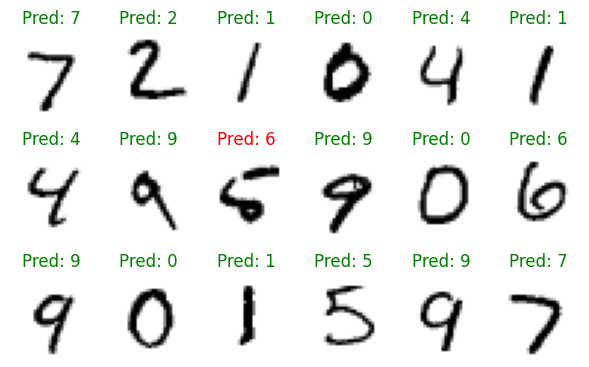

In [ ]:
yp = model_dnn_2(X)
plot_images(X, y, yp, 3, 6)

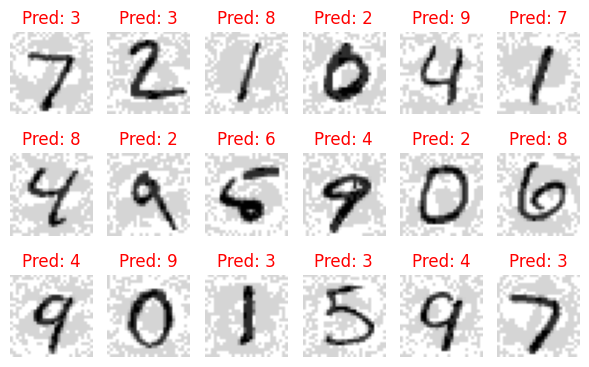

In [ ]:
### Illustrate attacked images
delta = fgsm(model_dnn_2, X, y, 0.1)
yp = model_dnn_2(X + delta)
plot_images(X+delta, y, yp, 3, 6)

Fully connected networks are particularly succeptible to these issues, and ConvNets slightly less so.

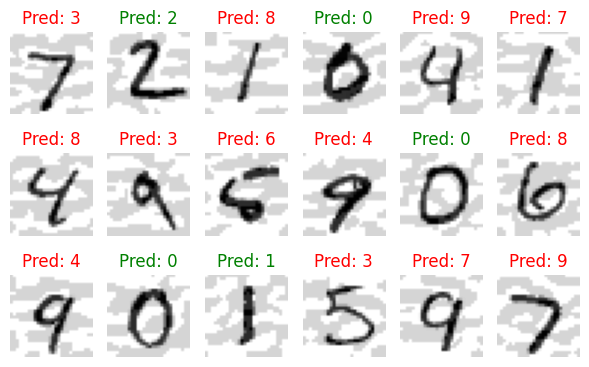

In [ ]:
### Illustrate attacked images
delta = fgsm(model_cnn, X, y, 0.1)
yp = model_cnn(X + delta)
plot_images(X+delta, y, yp, 3, 6)

total test errors of our classifiers when evaulating against FGSM adversarial attack

In [ ]:
def epoch_adversarial(model, loader, attack, *args):
    total_loss, total_err = 0.,0.
    for X,y in loader:
        X,y = X.to(device), y.to(device)
        delta = attack(model, X, y, *args)
        yp = model(X+delta)
        loss = nn.CrossEntropyLoss()(yp,y)

        total_err += (yp.max(dim=1)[1] != y).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)

In [ ]:
print("2-layer DNN:", epoch_adversarial(model_dnn_2, test_loader, fgsm, 0.1)[0])
print("4-layer DNN:", epoch_adversarial(model_dnn_4, test_loader, fgsm, 0.1)[0])
print("        CNN:", epoch_adversarial(model_cnn, test_loader, fgsm, 0.1)[0])


2-layer DNN: 0.9327
4-layer DNN: 0.9173
        CNN: 0.5386


## Lower bound (Projected Gradient Descent)

In [ ]:
def pgd(model, X, y, epsilon, alpha, num_iter):
    """ Construct FGSM adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    for t in range(num_iter):
        loss = nn.CrossEntropyLoss()(model(X + delta), y)
        loss.backward()
        delta.data = (delta + X.shape[0]*alpha*delta.grad.data).clamp(-epsilon,epsilon)
        delta.grad.zero_()
    return delta.detach()

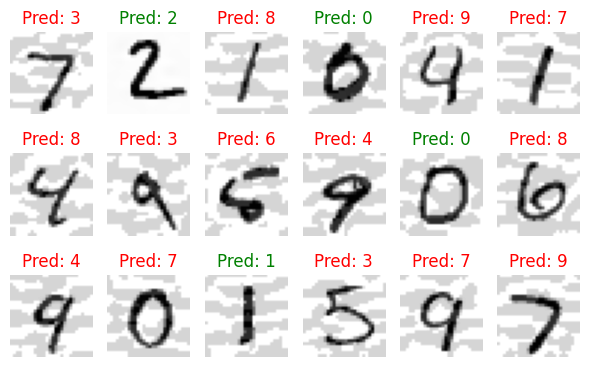

In [ ]:
### Illustrate attacked images
delta = pgd(model_cnn, X, y, 0.1, 1e4, 1000)
yp = model_cnn(X + delta)
plot_images(X+delta, y, yp, 3, 6)

In [ ]:
delta = torch.zeros_like(X, requires_grad=True)
loss = nn.CrossEntropyLoss()(model_cnn(X + delta), y)
loss.backward()
print(delta.grad.abs().mean().item())

5.153623988007894e-06


Extremely large step size α=1e4.
This is all due to the fact that gradient with respect to δ and δ=0 is usually very small,so we need to scale it by a relatively large α to make any progress at all.

 Once we “break out” of the initial region around δ=0, the gradients typically increase in magnitude substantially, and at this point our large α is too large, and the method takes too big a step toward the boundary (effectively just acting like FGSM).

## Lower bound (Steepest Descent)

In [ ]:
def pgd_linf(model, X, y, epsilon, alpha, num_iter):
    """ Construct FGSM adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    for t in range(num_iter):
        loss = nn.CrossEntropyLoss()(model(X + delta), y)
        loss.backward()
        delta.data = (delta + alpha*delta.grad.detach().sign()).clamp(-epsilon,epsilon)
        delta.grad.zero_()
    return delta.detach()

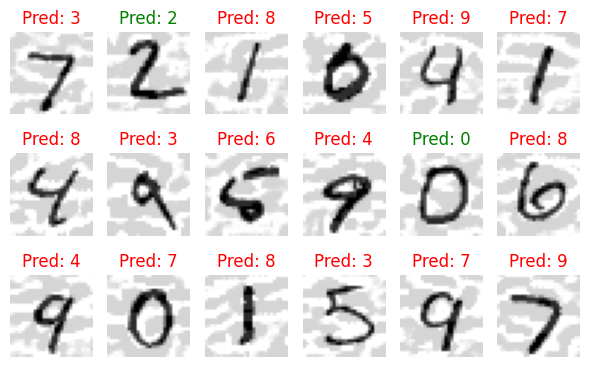

In [ ]:
### Illustrate attacked images
delta = pgd_linf(model_cnn, X, y, epsilon=0.1, alpha=1e-2, num_iter=40)
yp = model_cnn(X + delta)
plot_images(X+delta, y, yp, 3, 6)

In [ ]:
print("2-layer DNN:", epoch_adversarial(model_dnn_2, test_loader, pgd_linf, 0.1, 1e-2, 40)[0])
print("4-layer DNN:", epoch_adversarial(model_dnn_4, test_loader, pgd_linf, 0.1, 1e-2, 40)[0])
print("CNN:", epoch_adversarial(model_cnn, test_loader, pgd_linf, 0.1, 1e-2, 40)[0])

2-layer DNN: 0.9682
4-layer DNN: 0.9815
CNN: 0.8005


## Lower bound (Randomization)

In [ ]:
def pgd_linf_rand(model, X, y, epsilon, alpha, num_iter, restarts):
    """ Construct PGD adversarial examples on the samples X, with random restarts"""
    max_loss = torch.zeros(y.shape[0]).to(y.device)
    max_delta = torch.zeros_like(X)

    for i in range(restarts):
        delta = torch.rand_like(X, requires_grad=True)
        delta.data = delta.data * 2 * epsilon - epsilon

        for t in range(num_iter):
            loss = nn.CrossEntropyLoss()(model(X + delta), y)
            loss.backward()
            delta.data = (delta + alpha*delta.grad.detach().sign()).clamp(-epsilon,epsilon)
            delta.grad.zero_()

        all_loss = nn.CrossEntropyLoss(reduction='none')(model(X+delta),y)
        max_delta[all_loss >= max_loss] = delta.detach()[all_loss >= max_loss]
        max_loss = torch.max(max_loss, all_loss)

    return max_delta


In [ ]:
print("CNN:", epoch_adversarial(model_cnn, test_loader, pgd_linf_rand, 0.1, 1e-2, 40, 10)[0])

CNN: 0.8206


## Lower bound (Targeted attack)

In [ ]:
def pgd_linf_targ(model, X, y, epsilon, alpha, num_iter, y_targ):
    """ Construct targeted adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    for t in range(num_iter):
        yp = model(X + delta)
        loss = (yp[:,y_targ] - yp.gather(1,y[:,None])[:,0]).sum()
        loss.backward()
        delta.data = (delta + alpha*delta.grad.detach().sign()).clamp(-epsilon,epsilon)
        delta.grad.zero_()
    return delta.detach()

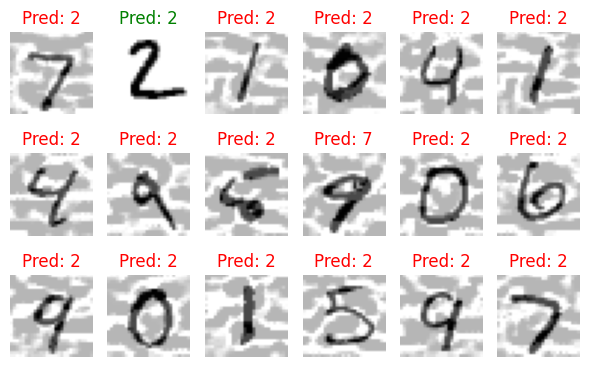

In [ ]:
delta = pgd_linf_targ(model_cnn, X, y, epsilon=0.2, alpha=1e-2, num_iter=40, y_targ=2)
yp = model_cnn(X + delta)
plot_images(X+delta, y, yp, 3, 6)

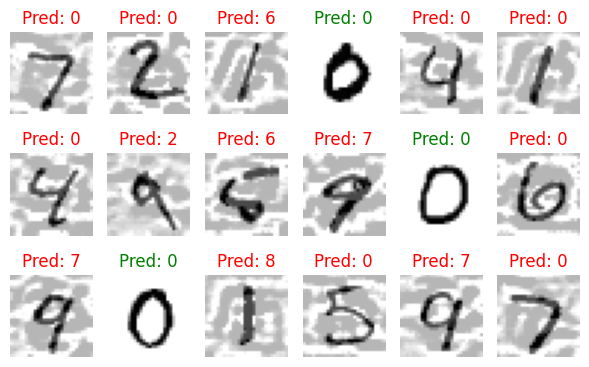

In [ ]:
delta = pgd_linf_targ(model_cnn, X, y, epsilon=0.2, alpha=1e-2, num_iter=40, y_targ=0)
yp = model_cnn(X + delta)
plot_images(X+delta, y, yp, 3, 6)

## Lower bound (Targeted attack (Minimizing all other classes))

In [ ]:
def pgd_linf_targ2(model, X, y, epsilon, alpha, num_iter, y_targ):
    """ Construct targeted adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    for t in range(num_iter):
        yp = model(X + delta)
        loss = 2*yp[:,y_targ].sum() - yp.sum()
        loss.backward()
        delta.data = (delta + alpha*delta.grad.detach().sign()).clamp(-epsilon,epsilon)
        delta.grad.zero_()
    return delta.detach()

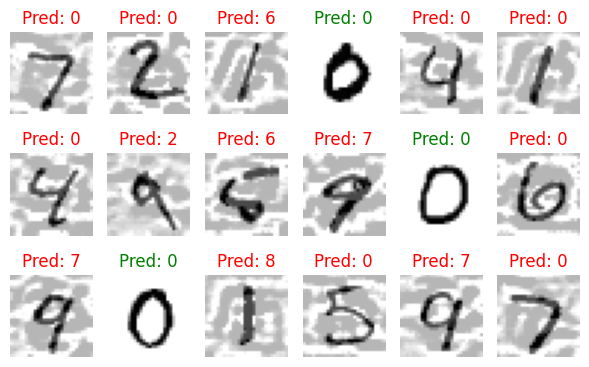

In [ ]:
delta = pgd_linf_targ(model_cnn, X, y, epsilon=0.2, alpha=1e-2, num_iter=40, y_targ=0)
yp = model_cnn(X + delta)
plot_images(X+delta, y, yp, 3, 6)

## Lower bound (Non-ℓ∞ norms)

In [ ]:
def norms(Z):
    """Compute norms over all but the first dimension"""
    return Z.view(Z.shape[0], -1).norm(dim=1)[:,None,None,None]


def pgd_l2(model, X, y, epsilon, alpha, num_iter):
    delta = torch.zeros_like(X, requires_grad=True)
    for t in range(num_iter):
        loss = nn.CrossEntropyLoss()(model(X + delta), y)
        loss.backward()
        delta.data += alpha*delta.grad.detach() / norms(delta.grad.detach())
        delta.data = torch.min(torch.max(delta.detach(), -X), 1-X) # clip X+delta to [0,1]
        delta.data *= epsilon / norms(delta.detach()).clamp(min=epsilon)
        delta.grad.zero_()

    return delta.detach()

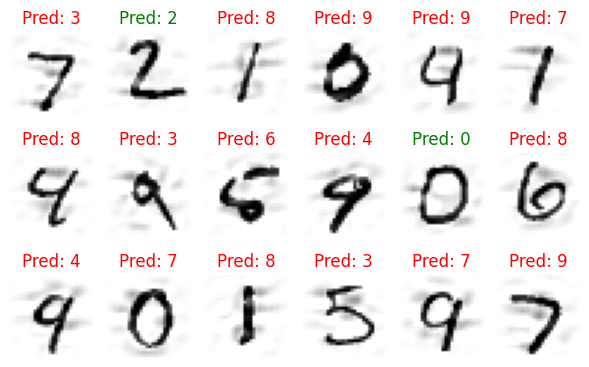

In [ ]:
delta = pgd_l2(model_cnn, X, y, epsilon=2, alpha=0.1, num_iter=40)
yp = model_cnn(X + delta)
plot_images(X+delta, y, yp, 3, 6)

In [ ]:
print("2-layer DNN:", epoch_adversarial(model_dnn_2, test_loader, pgd_l2, 2, 0.1, 40)[0])
print("4-layer DNN:", epoch_adversarial(model_dnn_4, test_loader, pgd_l2, 2, 0.1, 40)[0])
print("CNN:", epoch_adversarial(model_cnn, test_loader, pgd_l2, 2, 0.1, 40)[0])

2-layer DNN: 0.9308
4-layer DNN: 0.9366
CNN: 0.8341


## Exactly solving the inner maximization (combinatorial optimization)

In [ ]:
def bound_propagation(model, initial_bound):
    l, u = initial_bound
    bounds = []

    for layer in model:
        if isinstance(layer, Flatten):
            l_ = Flatten()(l)
            u_ = Flatten()(u)
        elif isinstance(layer, nn.Linear):
            l_ = (layer.weight.clamp(min=0) @ l.t() + layer.weight.clamp(max=0) @ u.t()
                  + layer.bias[:,None]).t()
            u_ = (layer.weight.clamp(min=0) @ u.t() + layer.weight.clamp(max=0) @ l.t()
                  + layer.bias[:,None]).t()
        elif isinstance(layer, nn.Conv2d):
            l_ = (nn.functional.conv2d(l, layer.weight.clamp(min=0), bias=None,
                                       stride=layer.stride, padding=layer.padding,
                                       dilation=layer.dilation, groups=layer.groups) +
                  nn.functional.conv2d(u, layer.weight.clamp(max=0), bias=None,
                                       stride=layer.stride, padding=layer.padding,
                                       dilation=layer.dilation, groups=layer.groups) +
                  layer.bias[None,:,None,None])

            u_ = (nn.functional.conv2d(u, layer.weight.clamp(min=0), bias=None,
                                       stride=layer.stride, padding=layer.padding,
                                       dilation=layer.dilation, groups=layer.groups) +
                  nn.functional.conv2d(l, layer.weight.clamp(max=0), bias=None,
                                       stride=layer.stride, padding=layer.padding,
                                       dilation=layer.dilation, groups=layer.groups) +
                  layer.bias[None,:,None,None])

        elif isinstance(layer, nn.ReLU):
            l_ = l.clamp(min=0)
            u_ = u.clamp(min=0)

        bounds.append((l_, u_))
        l,u = l_, u_
    return bounds


In [ ]:
epsilon = 0.1
bounds = bound_propagation(model_cnn, ((X - epsilon).clamp(min=0), (X + epsilon).clamp(max=1)))
print("lower bound: ", bounds[-1][0][0].detach().cpu().numpy())
print("upper bound: ", bounds[-1][1][0].detach().cpu().numpy())

NameError: ignored

# Solving the outer minimization


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [2]:
mnist_train = datasets.MNIST("../data", train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.MNIST("../data", train=False, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(mnist_train, batch_size = 100, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size = 100, shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 116375449.59it/s]


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 22998992.56it/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 35317053.65it/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 5334788.23it/s]


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
device

device(type='cuda', index=0)

In [5]:
torch.manual_seed(0)

In [6]:
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.shape[0], -1)

In [7]:
model_cnn = nn.Sequential(nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(),
                          nn.Conv2d(32, 32, 3, padding=1, stride=2), nn.ReLU(),
                          nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
                          nn.Conv2d(64, 64, 3, padding=1, stride=2), nn.ReLU(),
                          Flatten(),
                          nn.Linear(7*7*64, 100), nn.ReLU(),
                          nn.Linear(100, 10)).to(device)

In [8]:
def fgsm(model, X, y, epsilon=0.1):
    """ Construct FGSM adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    loss = nn.CrossEntropyLoss()(model(X + delta), y)
    loss.backward()
    return epsilon * delta.grad.detach().sign()

In [9]:
def pgd_linf(model, X, y, epsilon=0.1, alpha=0.01, num_iter=20, randomize=False):
    """ Construct FGSM adversarial examples on the examples X"""
    if randomize:
        delta = torch.rand_like(X, requires_grad=True)
        delta.data = delta.data * 2 * epsilon - epsilon
    else:
        delta = torch.zeros_like(X, requires_grad=True)

    for t in range(num_iter):
        loss = nn.CrossEntropyLoss()(model(X + delta), y)
        loss.backward()
        delta.data = (delta + alpha*delta.grad.detach().sign()).clamp(-epsilon,epsilon)
        delta.grad.zero_()
    return delta.detach()

## Clean training

In [10]:
def epoch(loader, model, opt=None):
    """Standard training/evaluation epoch over the dataset"""
    total_loss, total_err = 0.,0.
    for X,y in loader:
        X,y = X.to(device), y.to(device)
        yp = model(X)
        loss = nn.CrossEntropyLoss()(yp,y)
        if opt:
            opt.zero_grad()
            loss.backward()
            opt.step()

        total_err += (yp.max(dim=1)[1] != y).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)

In [11]:
def epoch_adversarial(loader, model, attack, opt=None, **kwargs):
    """Adversarial training/evaluation epoch over the dataset"""
    total_loss, total_err = 0.,0.
    for X,y in loader:
        X,y = X.to(device), y.to(device)
        delta = attack(model, X, y, **kwargs)
        yp = model(X+delta)
        loss = nn.CrossEntropyLoss()(yp,y)
        if opt:
            opt.zero_grad()
            loss.backward()
            opt.step()

        total_err += (yp.max(dim=1)[1] != y).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)

In [12]:
opt = optim.SGD(model_cnn.parameters(), lr=1e-1)

In [13]:
for t in range(10):
    train_err, train_loss = epoch(train_loader, model_cnn, opt)
    test_err, test_loss = epoch(test_loader, model_cnn)
    adv_err, adv_loss = epoch_adversarial(test_loader, model_cnn, pgd_linf)
    if t == 4:
        for param_group in opt.param_groups:
            param_group["lr"] = 1e-2
    print(*("{:.6f}".format(i) for i in (train_err, test_err, adv_err)), sep="\t")

0.280933	0.031000	0.640300
0.026000	0.020200	0.658000
0.017483	0.016400	0.656300
0.013050	0.015900	0.681000
0.009483	0.013800	0.735100
0.003750	0.010200	0.710500
0.002683	0.010200	0.716600
0.002333	0.010400	0.711700
0.002050	0.010700	0.716400
0.001683	0.010600	0.721400


 clean error is quite low, but the adversarial error is quite high

In [14]:
torch.save(model_cnn.state_dict(), "model_cnn.pt")

In [15]:
model_cnn.load_state_dict(torch.load("model_cnn.pt"))

<All keys matched successfully>

## Adversarial training

In [16]:
model_cnn_robust = nn.Sequential(nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(),
                                 nn.Conv2d(32, 32, 3, padding=1, stride=2), nn.ReLU(),
                                 nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
                                 nn.Conv2d(64, 64, 3, padding=1, stride=2), nn.ReLU(),
                                 Flatten(),
                                 nn.Linear(7*7*64, 100), nn.ReLU(),
                                 nn.Linear(100, 10)).to(device)

In [17]:
opt = optim.SGD(model_cnn_robust.parameters(), lr=1e-1)

In [18]:
for t in range(10):
    train_err, train_loss = epoch_adversarial(train_loader, model_cnn_robust, pgd_linf, opt)
    test_err, test_loss = epoch(test_loader, model_cnn_robust)
    adv_err, adv_loss = epoch_adversarial(test_loader, model_cnn_robust, pgd_linf)
    if t == 4:
        for param_group in opt.param_groups:
            param_group["lr"] = 1e-2
    print(*("{:.6f}".format(i) for i in (train_err, test_err, adv_err)), sep="\t")

0.678233	0.099800	0.231800
0.092083	0.019000	0.055700
0.050000	0.016000	0.043800
0.037900	0.015300	0.043500
0.031633	0.011600	0.032800
0.020867	0.009800	0.028300
0.019233	0.009600	0.029300
0.018900	0.010200	0.027500
0.017917	0.009100	0.028400
0.017667	0.009500	0.027800


In [19]:
torch.save(model_cnn_robust.state_dict(), "model_cnn_robust.pt")

In [20]:
model_cnn_robust.load_state_dict(torch.load("model_cnn_robust.pt"))

<All keys matched successfully>

So with adversarial training, we are able to get a model that has an error rate of just 2.8%, compared to the 71% that our original model had

## Evaluating our model against some different attacks

In [21]:
print("FGSM: ", epoch_adversarial(test_loader, model_cnn_robust, fgsm)[0])


FGSM:  0.0254


FGSM indeed works worse than even the PGD attack we trained against, because FGSM is really just one step of PGD with a step size of α=ϵ. So it’s not surprising it does worse. Let’s try running PGD for longer.



In [22]:
print("PGD, 40 iter: ", epoch_adversarial(test_loader, model_cnn_robust, pgd_linf, num_iter=40)[0])

PGD, 40 iter:  0.028


Error increases a little bit, but well within the bounds of what we might think in reasonable (you can try running for longer, and see that it doesn’t change much)

In [23]:
print("PGD, small_alpha: ", epoch_adversarial(test_loader, model_cnn_robust, pgd_linf, num_iter=40, alpha=0.05)[0])

PGD, small_alpha:  0.0278


In [24]:
print("PGD, randomized: ", epoch_adversarial(test_loader, model_cnn_robust, pgd_linf,
                                             num_iter=40, randomize=True)[0])

PGD, randomized:  0.0279


## Loss surface of standard network

A projection of the loss function along two dimensions in the input space (one the direction of the actual gradient, and one a random direction).



In [34]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LightSource

In [25]:
for X,y in test_loader:
    X,y = X.to(device), y.to(device)
    break

In [35]:
def draw_loss(model, X, epsilon):
    Xi, Yi = np.meshgrid(np.linspace(-epsilon, epsilon,100), np.linspace(-epsilon,epsilon,100))

    def grad_at_delta(delta):
        delta.requires_grad_(True)
        nn.CrossEntropyLoss()(model(X+delta), y[0:1]).backward()
        return delta.grad.detach().sign().view(-1).cpu().numpy()

    dir1 = grad_at_delta(torch.zeros_like(X, requires_grad=True))
    delta2 = torch.zeros_like(X, requires_grad=True)
    delta2.data = torch.tensor(dir1).view_as(X).to(device)
    dir2 = grad_at_delta(delta2)
    np.random.seed(0)
    dir2 = np.sign(np.random.randn(dir1.shape[0]))

    all_deltas = torch.tensor((np.array([Xi.flatten(), Yi.flatten()]).T @
                              np.array([dir2, dir1])).astype(np.float32)).to(device)
    yp = model(all_deltas.view(-1,1,28,28) + X)
    Zi = nn.CrossEntropyLoss(reduction="none")(yp, y[0:1].repeat(yp.shape[0])).detach().cpu().numpy()
    Zi = Zi.reshape(*Xi.shape)
    #Zi = (Zi-Zi.min())/(Zi.max() - Zi.min())

    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(projection='3d')
    ls = LightSource(azdeg=0, altdeg=200)
    rgb = ls.shade(Zi, plt.cm.coolwarm)

    surf = ax.plot_surface(Xi, Yi, Zi, rstride=1, cstride=1, linewidth=0,
                       antialiased=True, facecolors=rgb)

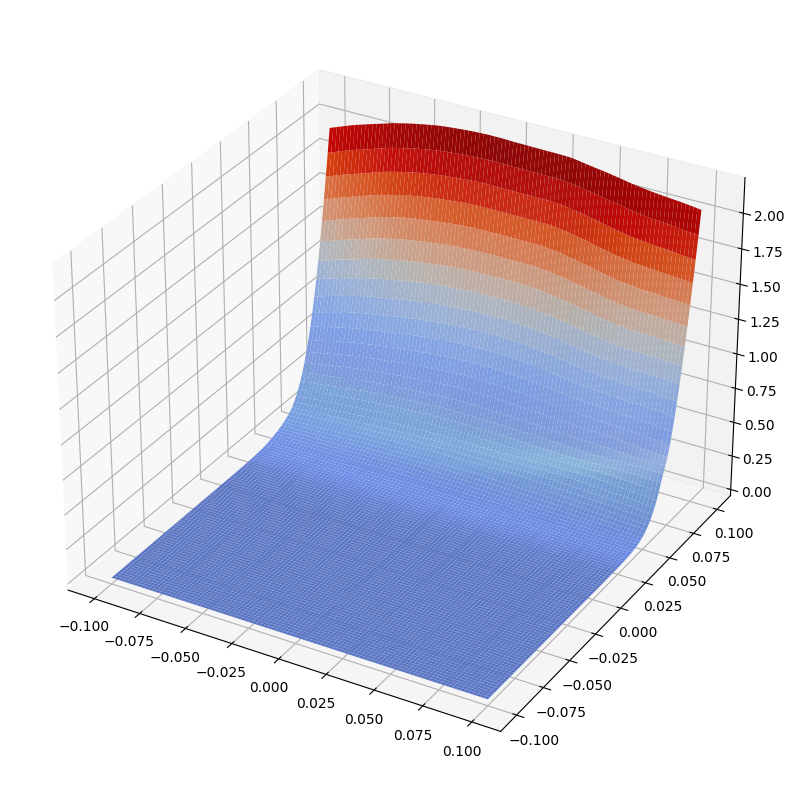

In [36]:
draw_loss(model_cnn, X[0:1], 0.1)

## Loss surface of robust network

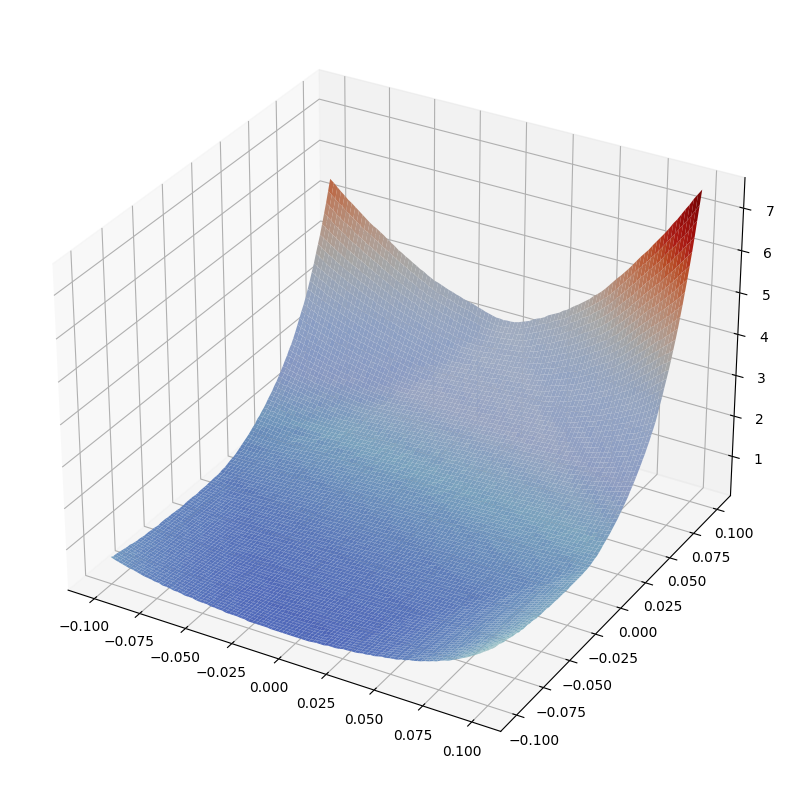

In [37]:
draw_loss(model_cnn_robust, X[0:1], 0.1)

The robust model has a loss that is quite flat both in the gradient direction (that is the steeper direction), and in the random direction, whereas the traditionally trained model varies quite rapidly both in the gradient direction and (after moving some in the gradient direction) in the random direction.

## Relaxation-based robust training

In [38]:
def bound_propagation(model, initial_bound):
    l, u = initial_bound
    bounds = []

    for layer in model:
        if isinstance(layer, Flatten):
            l_ = Flatten()(l)
            u_ = Flatten()(u)
        elif isinstance(layer, nn.Linear):
            l_ = (layer.weight.clamp(min=0) @ l.t() + layer.weight.clamp(max=0) @ u.t()
                  + layer.bias[:,None]).t()
            u_ = (layer.weight.clamp(min=0) @ u.t() + layer.weight.clamp(max=0) @ l.t()
                  + layer.bias[:,None]).t()
        elif isinstance(layer, nn.Conv2d):
            l_ = (nn.functional.conv2d(l, layer.weight.clamp(min=0), bias=None,
                                       stride=layer.stride, padding=layer.padding,
                                       dilation=layer.dilation, groups=layer.groups) +
                  nn.functional.conv2d(u, layer.weight.clamp(max=0), bias=None,
                                       stride=layer.stride, padding=layer.padding,
                                       dilation=layer.dilation, groups=layer.groups) +
                  layer.bias[None,:,None,None])

            u_ = (nn.functional.conv2d(u, layer.weight.clamp(min=0), bias=None,
                                       stride=layer.stride, padding=layer.padding,
                                       dilation=layer.dilation, groups=layer.groups) +
                  nn.functional.conv2d(l, layer.weight.clamp(max=0), bias=None,
                                       stride=layer.stride, padding=layer.padding,
                                       dilation=layer.dilation, groups=layer.groups) +
                  layer.bias[None,:,None,None])

        elif isinstance(layer, nn.ReLU):
            l_ = l.clamp(min=0)
            u_ = u.clamp(min=0)

        bounds.append((l_, u_))
        l,u = l_, u_
    return bounds

In [39]:
def interval_based_bound(model, c, bounds, idx):
    # requires last layer to be linear
    cW = c.t() @ model[-1].weight
    cb = c.t() @ model[-1].bias

    l,u = bounds[-2]
    return (cW.clamp(min=0) @ l[idx].t() + cW.clamp(max=0) @ u[idx].t() + cb[:,None]).t()


In [42]:
def robust_bound_error(model, X, y, epsilon):
    initial_bound = (X - epsilon, X + epsilon)
    err = 0
    for y0 in range(10):
        C = -torch.eye(10).to(device)
        C[y0,:] += 1
        err += (interval_based_bound(model, C, bounds, y==y0).min(dim=1)[0] < 0).sum().item()
    return err

In [44]:
def epoch_robust_err(loader, model, epsilon):
    total_err = 0

    C = [-torch.eye(10).to(device) for _ in range(10)]
    for y0 in range(10):
        C[y0][y0,:] += 1

    for X,y in loader:
        X,y = X.to(device), y.to(device)
        initial_bound = (X - epsilon, X + epsilon)
        bounds = bound_propagation(model, initial_bound)
        for y0 in range(10):
            lower_bound = interval_based_bound(model, C[y0], bounds, y==y0)
            total_err += (lower_bound.min(dim=1)[0] < 0).sum().item()
    return total_err / len(loader.dataset)

In [45]:
epoch_robust_err(test_loader, model_cnn_robust, 0.1)

1.0

Unfortunately, the interval-based bound is entirely vaccous for our (robustly) trained classifier.

In [46]:
epoch_robust_err(test_loader, model_cnn_robust, 0.0001)

0.0191

That doesn’t seem particularly useful, and indeed, it is a property of virtually all the relaxation-based verification approaches, is that they are vaccuous when evaluated upon a network trained without knowledge of these bounds.

Additionally, these errors tend to accumulate with the depth of the network, precisely because the interval bounds as we have presented them also tend to get looser with each layer of the network.

## Training using provable criteria

use the interval bounds to upper bound the cross entropy loss of a classifier, and then minimize this upper bound.

In [47]:
def epoch_robust_bound(loader, model, epsilon, opt=None):
    total_err = 0
    total_loss = 0

    C = [-torch.eye(10).to(device) for _ in range(10)]
    for y0 in range(10):
        C[y0][y0,:] += 1

    for X,y in loader:
        X,y = X.to(device), y.to(device)
        initial_bound = (X - epsilon, X + epsilon)
        bounds = bound_propagation(model, initial_bound)
        loss = 0
        for y0 in range(10):
            if sum(y==y0) > 0:
                lower_bound = interval_based_bound(model, C[y0], bounds, y==y0)
                loss += nn.CrossEntropyLoss(reduction='sum')(-lower_bound, y[y==y0]) / X.shape[0]
                total_err += (lower_bound.min(dim=1)[0] < 0).sum().item()
        total_loss += loss.item() * X.shape[0]
        #print(loss.item())
        if opt:
            opt.zero_grad()
            loss.backward()
            opt.step()
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)


In [48]:
torch.manual_seed(0)

In [49]:
model_cnn_robust_2 = nn.Sequential(nn.Conv2d(1, 32, 3, padding=1, stride=2), nn.ReLU(),
                                   nn.Conv2d(32, 32, 3, padding=1, ), nn.ReLU(),
                                   nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
                                   nn.Conv2d(64, 64, 3, padding=1, stride=2), nn.ReLU(),
                                   Flatten(),
                                   nn.Linear(7*7*64, 100), nn.ReLU(),
                                   nn.Linear(100, 10)).to(device)

In [50]:
opt = optim.SGD(model_cnn_robust_2.parameters(), lr=1e-1)

Finally, let’s train our model using this robust loss bound. Note that training rovably robust models is a bit of a tricky business. If we start out immediately by trying to train our robust bound with the full ϵ=0.1, the model will collapse to just predicting equal probability for all digits, and will never recover. Instead, to reliably train such models we need to schedule ϵ during the training process, starting with a small ϵ and gradually raising it to the desired level. The schedule we use below was picked rather randomly, and we can do much better with a bit of tweaking, but it serves our basic purpose.

In [51]:
eps_schedule = [0.0, 0.0001, 0.001, 0.01, 0.01, 0.05, 0.05, 0.05, 0.05, 0.05] + 15*[0.1]

In [52]:
print("Train Eps", "Train Loss*", "Test Err", "Test Robust Err", sep="\t")
for t in range(len(eps_schedule)):
    train_err, train_loss = epoch_robust_bound(train_loader, model_cnn_robust_2, eps_schedule[t], opt)
    test_err, test_loss = epoch(test_loader, model_cnn_robust_2)
    adv_err, adv_loss = epoch_robust_bound(test_loader, model_cnn_robust_2, 0.1)
    #if t == 4:
    #    for param_group in opt.param_groups:
    #        param_group["lr"] = 1e-2

    print(*("{:.6f}".format(i) for i in (eps_schedule[t], train_loss, test_err, adv_err)), sep="\t")

Train Eps	Train Loss*	Test Err	Test Robust Err
0.000000	0.846256	0.030500	1.000000
0.000100	0.127159	0.020300	1.000000
0.001000	0.122041	0.018500	1.000000
0.010000	0.365171	0.032700	1.000000
0.010000	0.169466	0.026700	1.000000
0.050000	2.321620	0.886500	0.942000
0.050000	2.301557	0.886500	0.889300
0.050000	2.301450	0.886500	0.888300
0.050000	2.301527	0.886500	0.890200
0.050000	2.301445	0.886500	0.888700
0.100000	2.301712	0.886500	0.886500
0.100000	2.301468	0.886500	0.886500
0.100000	2.301555	0.886500	0.886500
0.100000	2.301547	0.886500	0.886500
0.100000	2.301512	0.886500	0.886500
0.100000	2.301440	0.886500	0.886500
0.100000	2.301490	0.886500	0.886500
0.100000	2.301456	0.886500	0.886500
0.100000	2.301428	0.886500	0.886500
0.100000	2.301501	0.886500	0.886500
0.100000	2.301555	0.886500	0.886500
0.100000	2.301473	0.886500	0.886500
0.100000	2.301522	0.886500	0.886500
0.100000	2.301452	0.897200	0.897200
0.100000	2.301493	0.886500	0.886500


In [53]:
torch.save(model_cnn_robust_2.state_dict(), "model_cnn_robust_2.pt")

It’s not going to set any records, but what we have here is an MNIST model that where no ℓ∞ attack of norm bounded by ϵ=0.1 will ever be able to cause the classifier to experience more than 9.67% error on the test set of MNIST (acheiving a “clean” error of 5.15%). And just how bad can a real adversarial attack do? It’s of course hard to say for sure, but let’s see what PGD does.

In [54]:
print("PGD, 40 iter: ", epoch_adversarial(test_loader, model_cnn_robust_2, pgd_linf, num_iter=40)[0])

PGD, 40 iter:  0.8865
